# Classifying images of cats and Dogs using CNN

In [4]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras import optimizers
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

### Setting parameters

In [5]:
base_path = './dataset/'
batch_size = 32
img_size = 60
epochs = 100
result = ["CAT", "DOG"]

## Understanding and visualising the Test Data

We have a data set of 10000 images, Out of which 5000 images are of cat and 5000 are of dogs. 
We have distributed the data into 3 layers. 
1. Traing Data 
    3500 images of cats and dogs each. Total 7000 images
2. Validation Data
    1000 images of cats and dogs each. Total 2000 images.
3. Test Data
    500 images of cats and dogs each. Total 1000 images

In [6]:
num_cats_tr = len(os.listdir())
num_cats_tr = len(os.listdir('./dataset/training_set/cats'))
num_dogs_tr = len(os.listdir('./dataset/training_set/dogs'))

num_cats_val = len(os.listdir('./dataset/val_set/cats'))
num_dogs_val = len(os.listdir('./dataset/val_set/dogs'))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val


In [7]:
print('Total training cat images:', num_cats_tr)
print('Total training dog images:', num_dogs_tr)

print('Total validation cat images:', num_cats_val)
print('Total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

Total training cat images: 4000
Total training dog images: 4000
Total validation cat images: 1000
Total validation dog images: 1000
--
Total training images: 8000
Total validation images: 2000


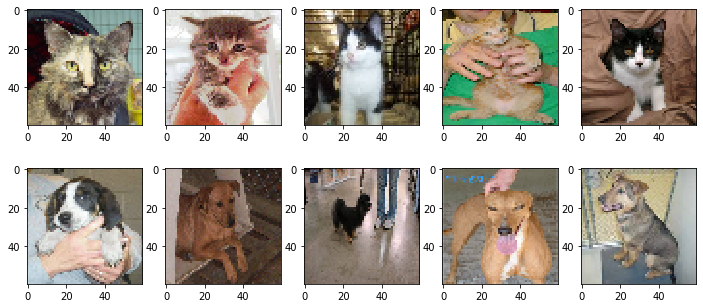

In [8]:
# let plot some of the initial example in the data
plt.figure(0, figsize=(12,20))
cpt = 0 
for ex in os.listdir(base_path + 'training_set/'):
    for i in range(1,6):
        cpt = cpt + 1
        plt.subplot(7,5, cpt)
        img = load_img(base_path+"training_set/"+ex+"/" + os.listdir(base_path + "training_set/" + ex)[i], target_size=(img_size, img_size))
        plt.imshow(img)

## Data Prepration

We have to Format images into appropriately pre-processed floating point tensors before being fed into the network. The steps involved in preparing these images are:

1. Read images from the disk
2. Decode contents of these images and convert it into proper grid format as per their RGB content
2. Convert them into floating point tensors
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

We can set this up in a couple of lines of code.

train_data_gen is used to process training images.
val_set is used to process validation set.

In [13]:
train_data_gen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=45,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    horizontal_flip=True)

<b>flow_from_directory</b> method is used to load images from the disk, apply rescaling, and resize them using below code.

In [14]:
train_set = train_data_gen.flow_from_directory(directory='dataset/training_set',
                                            target_size=(img_size, img_size),
                                            shuffle=True,
                                            batch_size=batch_size,
                                            class_mode='binary',
                                            seed=42)

Found 8000 images belonging to 2 classes.


In [15]:
val_data_gen = ImageDataGenerator(rescale=1./255)

In [16]:
val_set = val_data_gen.flow_from_directory(directory='dataset/val_set',
                                            target_size=(img_size, img_size),
                                            shuffle=True,
                                            batch_size=batch_size,
                                            class_mode='binary',
                                            seed=42)

Found 2000 images belonging to 2 classes.


## Model Creation

### Model Defination 

In this section we will define our neural network model. We will add the layers of our model. 

The model consists of four convolution blocks with a max pool layer in each of them.

Before the final Dense layers, we're also applying a Dropout probability of 0.25. It means that 25% of the values coming into the Dropout layer will be set to zero. This helps to prevent overfitting.

Then we have a fully connected layer with 128 units, with a relu activation function. The model will output class probabilities for two classes — dogs and cats — using softmax.

In [17]:
# Initialising the CNN
cnn_class = Sequential()

# layer 1
cnn_class.add(Conv2D(32, (3,3), padding = 'same', kernel_initializer='he_uniform', activation='relu', input_shape=(img_size, img_size, 3)))
cnn_class.add(MaxPooling2D(pool_size=(2,2)))
cnn_class.add(Dropout(0.15))


# layer 2
cnn_class.add(Conv2D(32, (3,3), padding = 'same', kernel_initializer='he_uniform', activation='relu'))
cnn_class.add(MaxPooling2D(pool_size=(2,2)))
cnn_class.add(Dropout(0.15))

# layer 3
cnn_class.add(Conv2D(64, (3,3), padding = 'same', kernel_initializer='he_uniform', activation='relu'))
cnn_class.add(MaxPooling2D(pool_size=(2,2)))
cnn_class.add(Dropout(0.15))

# Flattening
cnn_class.add(Flatten())


#fully connected layer
cnn_class.add(Dense(units=256, activation='relu', kernel_initializer='he_uniform'))
cnn_class.add(Dropout(0.15))

#output Layer
#cnn_class.add(Dense(units=2, activation='softmax'))
cnn_class.add(Dense(units=2, activation='softmax'))

### Compiling the Model
In this setp We will complie our model and define some required parmeters of our model.
We will use the adam optimizer. Since we output a softmax categorization, we'll use sparse_categorical_crossentropy as the loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, so we are passing in the metrics argument.

In [18]:
#adm = optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
sgd = SGD(lr=0.005, momentum=0.9)

In [19]:
cnn_class.compile(optimizer=sgd,
                  loss='sparse_categorical_crossentropy',
                   metrics=['accuracy']
                  )

In [20]:
history = cnn_class.fit_generator(train_set,
                                  steps_per_epoch = int(np.ceil(total_train/batch_size)),
                                  epochs=epochs,
                                  validation_data= val_set,
                                  validation_steps=int(np.ceil(total_val/batch_size)))


Epoch 1/100
250/250 [==============================] - 57s 229ms/step - loss: 0.7200 - accuracy: 0.5250 - val_loss: 0.6457 - val_accuracy: 0.5960
Epoch 2/100
250/250 [==============================] - 53s 210ms/step - loss: 0.6724 - accuracy: 0.5811 - val_loss: 0.7310 - val_accuracy: 0.6335
Epoch 3/100
250/250 [==============================] - 53s 212ms/step - loss: 0.6469 - accuracy: 0.6254 - val_loss: 0.5082 - val_accuracy: 0.6295
Epoch 4/100
250/250 [==============================] - 55s 219ms/step - loss: 0.6347 - accuracy: 0.6352 - val_loss: 0.6246 - val_accuracy: 0.6665
Epoch 5/100
250/250 [==============================] - 67s 266ms/step - loss: 0.6107 - accuracy: 0.6649 - val_loss: 0.6748 - val_accuracy: 0.6640
Epoch 6/100
250/250 [==============================] - 57s 227ms/step - loss: 0.5916 - accuracy: 0.6851 - val_loss: 0.5608 - val_accuracy: 0.7315
Epoch 7/100
250/250 [==============================] - 56s 225ms/step - loss: 0.5758 - accuracy: 0.6929 - val_loss: 0.4120 

250/250 [==============================] - 57s 227ms/step - loss: 0.4229 - accuracy: 0.8005 - val_loss: 0.4688 - val_accuracy: 0.8125
Epoch 56/100
250/250 [==============================] - 56s 224ms/step - loss: 0.4165 - accuracy: 0.8046 - val_loss: 0.2550 - val_accuracy: 0.8365
Epoch 57/100
250/250 [==============================] - 56s 225ms/step - loss: 0.4138 - accuracy: 0.8141 - val_loss: 0.5571 - val_accuracy: 0.8150
Epoch 58/100
250/250 [==============================] - 56s 223ms/step - loss: 0.4156 - accuracy: 0.8092 - val_loss: 0.1918 - val_accuracy: 0.8240
Epoch 59/100
250/250 [==============================] - 56s 225ms/step - loss: 0.4115 - accuracy: 0.8091 - val_loss: 0.3757 - val_accuracy: 0.8315
Epoch 60/100
250/250 [==============================] - 61s 245ms/step - loss: 0.4159 - accuracy: 0.8105 - val_loss: 0.0993 - val_accuracy: 0.8295
Epoch 61/100
250/250 [==============================] - 56s 225ms/step - loss: 0.4071 - accuracy: 0.8106 - val_loss: 0.3696 - val_a

#### Visualizing results of the training
We will plot the graph to visualise how our model got trained. We plotting the training and validation data's accuracy and loss to Visualize these values

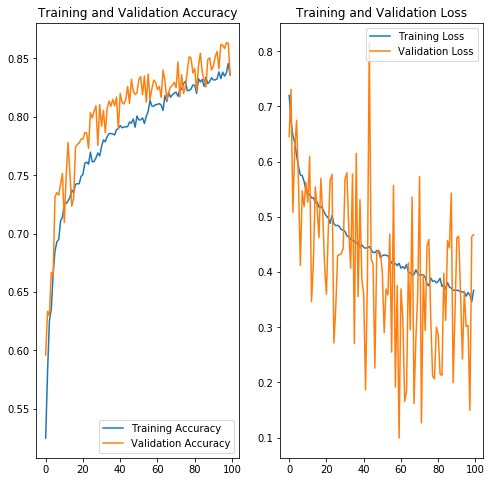

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Lets save the model parameter so that we do not have to fit it again. We can directly use this parameter to use the model in future. 

In [23]:
cnn_class.save_weights("cnn_class_copy3")

### Model Summary
Using summary() method we can see the shape and different parameter of our model.

In [24]:
cnn_class.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 60, 60, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)       

### Testing the model
Now We will used the model on the dataset which it has never seen before so that we can check how our model will performe with the new and real data.
W e are using the test data set which we have kept aside to evaluate our model

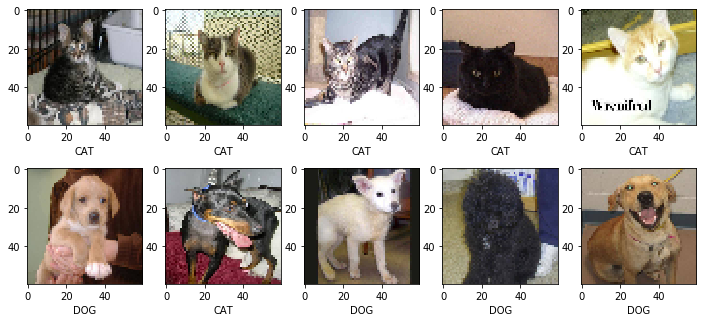

In [25]:
predictions = []
plt.figure(0, figsize=(12,20))
cpt = 0 
for ex in os.listdir(base_path + 'test_set/'):
    for i in range(0,10):
        cpt = cpt + 1
        ax = plt.subplot(7,5, cpt)
        img = load_img(base_path+"test_set/"+ex+"/" + os.listdir(base_path + "test_set/" + ex)[i], target_size=(img_size, img_size))
        plt.imshow(img)
        image = img_to_array(img) 
        image = np.expand_dims(image, axis=0)
        image /= 255.
        pr = cnn_class.predict(image)
        ax.set_xlabel(result[np.argmax(pr)])
        predictions.append(cnn_class.predict(image))        

In [26]:
predictions

[array([[0.9628565 , 0.03714349]], dtype=float32),
 array([[0.5290078, 0.4709922]], dtype=float32),
 array([[0.60493875, 0.3950613 ]], dtype=float32),
 array([[0.9804331 , 0.01956693]], dtype=float32),
 array([[0.99045277, 0.00954724]], dtype=float32),
 array([[0.00279685, 0.9972031 ]], dtype=float32),
 array([[0.6104574, 0.3895426]], dtype=float32),
 array([[0.35330245, 0.6466975 ]], dtype=float32),
 array([[0.22928002, 0.77072   ]], dtype=float32),
 array([[0.00321502, 0.9967849 ]], dtype=float32)]